# WetGrass analyzed using Edward. Learning parameters (transition prob matrices of latent nodes) using MetropolisHastings and HamiltonianMC

References
* https://discourse.edwardlib.org/t/simple-bayesian-network-sprinkler-example/258
* http://edwardlib.org/tutorials/batch-training
* https://discourse.edwardlib.org/t/parameter-learning-with-simple-bayesian-network-pymc3-vs-edward-edward-posteriors-not-converging-around-correct-parameter-values/653

In [1]:
import numpy as np
import tensorflow as tf

import edward as ed
import edward.models as edm
import edward.inferences as edi

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
import os
import sys
cur_dir_path = os.getcwd()
print(cur_dir_path)
os.chdir('../../')
qfog_path = os.getcwd()
print(qfog_path)
sys.path.insert(0,qfog_path)

/home/bob/Notebooks/Quantum/quantum-fog/jupyter-notebooks/inference_via_ext_software
/home/bob/Notebooks/Quantum/quantum-fog


In [3]:
import importlib
mm = importlib.import_module("jupyter-notebooks.inference_via_ext_software.ModelMaker")
mme = importlib.import_module("jupyter-notebooks.inference_via_ext_software.ModelMaker_Edward")
from graphs.BayesNet import *

In [4]:
# build BayesNet object bnet from bif file
in_path = "examples_cbnets/WetGrass.bif"
bnet = BayesNet.read_bif(in_path, False)

In [5]:
# build model (with no observed nodes) from bnet
prefix0 = "jupyter-notebooks/" +\
        "inference_via_ext_software/model_examples_c/"
file_prefix = prefix0 + "WetGrass_inf_obs_none"
mod_file = mme.ModelMaker_Edward.write_model_for_inf(file_prefix, bnet)

.py file with model can be found here

<a href="model_examples_c/WetGrass_inf_obs_none_edward.py">
model_examples_c/WetGrass_inf_obs_none_edward.py</a>

In [6]:
# -i option allows it to access notebook's namespace
%run -i $mod_file

In [7]:
# Generate data using edward model. Quantum Fog has its 
# own function to generate random probs from a graph
# directly from bnet. Here we let edward do it instead.

data_size = 1000

data = np.zeros([data_size, 4], dtype=int)
with tf.Session() as sess:
    for i in range(data_size):
        # data[:, i] doesn't work 
        data[i, :] = sess.run([Cloudy, Rain, Sprinkler, WetGrass])
print('data[0:5, :]\n', data[0:5, :])
print("data[0:5, 0]\n", data[0:5, 0])

data[0:5, :]
 [[0 0 1 1]
 [1 0 1 1]
 [1 1 0 1]
 [0 1 1 1]
 [1 1 0 1]]
data[0:5, 0]
 [0 1 1 0 1]


In [8]:
# del previous graph before we create a new one for parameter learning
tf.reset_default_graph()

In [9]:
prefix0 = "jupyter-notebooks/" +\
        "inference_via_ext_software/model_examples_c/"
file_prefix = prefix0 + "WetGrass_par_MC_obs_CW"
obs_vertices = ['Cloudy', "WetGrass"]
# Will go out of bounds if propo_scale too big.
# Chain of probabilities in [0, 1] so choose propo_scale << 1
mod_file = mme.ModelMaker_Edward.write_model_for_param_learning(file_prefix, 
        bnet, obs_vertices, inf_method='MC', propo_scale=.1)

.py file with model can be found here

<a href="model_examples_c/WetGrass_par_MC_obs_CW_edward.py">
model_examples_c/WetGrass_par_MC_obs_CW_edward.py</a>

In [10]:
# -i option allows it to access notebook's namespace

# The variable 'sam_size' (sample size of observed nodes) is used
# without value in the .py file and must be set to an int before
# running the .py file.

sam_size = data_size
%run -i $mod_file

In [11]:
def plot_hist(vtx, num_pts):
    print('true:')
    print(bnet.get_node_named(vtx).potential.pot_arr)
    fig, ax = plt.subplots(2, 2, figsize = (8, 8), sharex=True, sharey=True)
    plt.xlim(-.05,1.05)
    #plt.ylim(0,num_pts)
    for j1 in range(0, 2):
        for j2 in range(0, 2):
            arr_str = 'emp_' + vtx + '_q'
            ax[j1, j2].hist(eval(arr_str).params.eval()[
                data_size - num_pts : data_size][:, j1, j2], 
                bins=num_pts//10)
            ax[j1, j2].set_title('emp_' + vtx + '_q(' +
                                 str(j1) + ', ' + str(j2) + ')')
    plt.show()

In [12]:
q_dict = {probs_Rain: emp_Rain_q, 
          probs_Sprinkler: emp_Sprinkler_q}
data_dict = {Cloudy:data[:, 0], WetGrass:data[:, 3]}

## Metropolis Hastings

In [13]:
propo_dict = {probs_Rain: propo_Rain_q, 
              probs_Sprinkler: propo_Sprinkler_q}
inf = edi.MetropolisHastings(q_dict, propo_dict, data=data_dict)
inf.run()

1000/1000 [100%] ██████████████████████████████ Elapsed: 99s | Acceptance Rate: 0.470


true:
[[ 0.4  0.6]
 [ 0.5  0.5]]


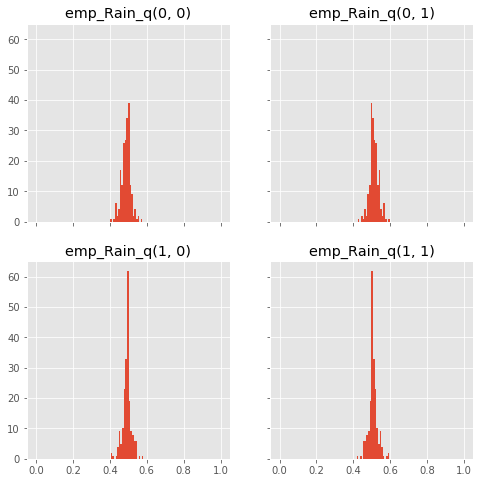

In [14]:
plot_hist('Rain', 200)

true:
[[ 0.2  0.8]
 [ 0.7  0.3]]


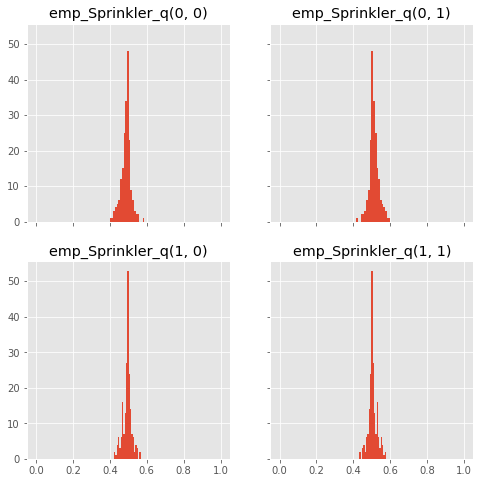

In [15]:
plot_hist('Sprinkler', 200)

## Hamiltonian MonteCarlo

In [16]:
# Doesn't work
# inf = edi.HMC(q_dict, data=data_dict)
# inf.run()